In [ ]:
from google.colab import files
uploaded = files.upload()

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Raw rows: 1600000
Using subset rows: 20000
>>> Baseline: Logistic Regression

Logistic Regression Accuracy: 0.7390  |  Macro F1: 0.7390
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      3024
           1       0.73      0.76      0.74      2976

    accuracy                           0.74      6000
   macro avg       0.74      0.74      0.74      6000
weighted avg       0.74      0.74      0.74      6000



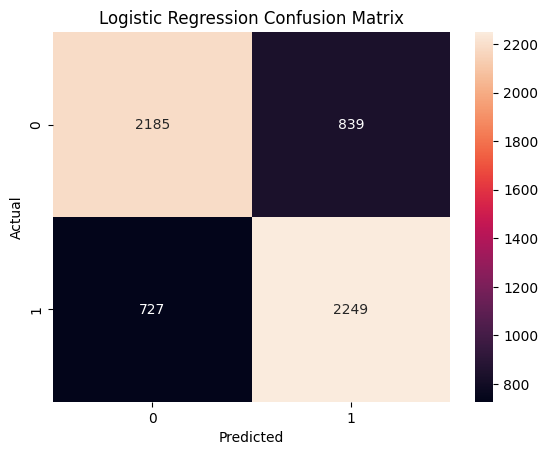

>>> Baseline: Random Forest

Random Forest Accuracy: 0.7330  |  Macro F1: 0.7329
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      3024
           1       0.72      0.76      0.74      2976

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000



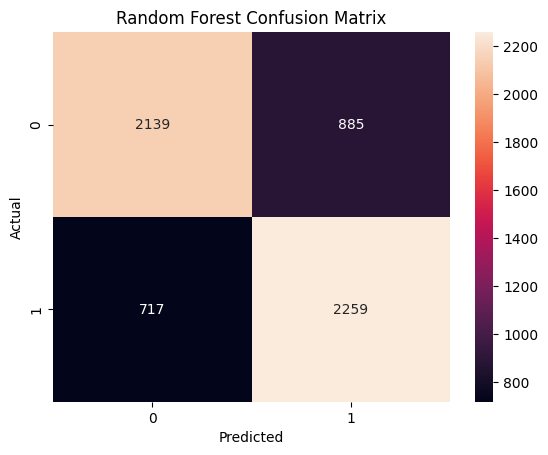

Train size: 14000 Test size: 6000
Train class counts before augmentation:
 label
0    7055
1    6945
Name: count, dtype: int64
Generated synthetic samples: 110
New train class counts:
 label
1    7055
0    7055
Name: count, dtype: int64
>>> Augmented: Logistic Regression

Logistic Regression (Augmented) Accuracy: 0.7388  |  Macro F1: 0.7388
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      3024
           1       0.73      0.76      0.74      2976

    accuracy                           0.74      6000
   macro avg       0.74      0.74      0.74      6000
weighted avg       0.74      0.74      0.74      6000



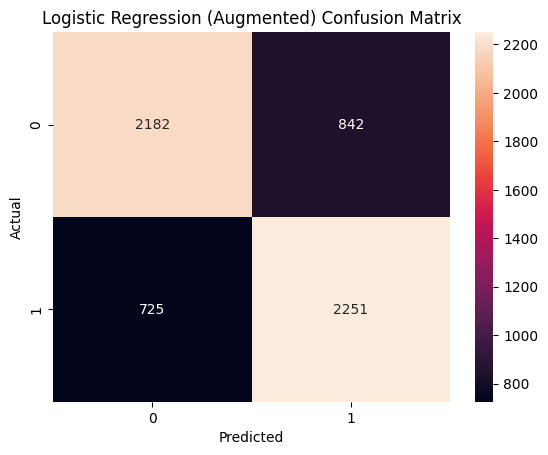

>>> Augmented: Random Forest

Random Forest (Augmented) Accuracy: 0.7303  |  Macro F1: 0.7303
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      3024
           1       0.72      0.75      0.73      2976

    accuracy                           0.73      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.73      0.73      0.73      6000



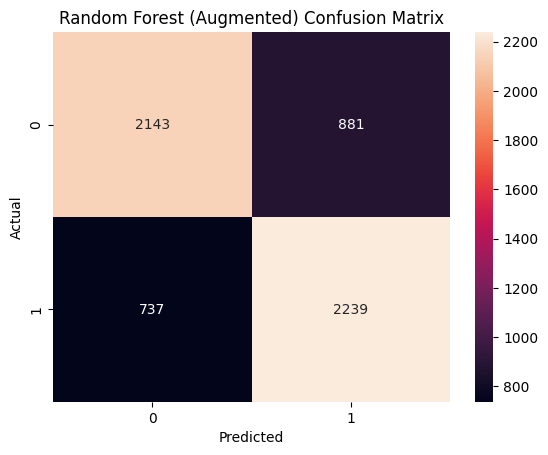

                 Model  Accuracy  Macro_F1
0      Logistic (base)  0.739000  0.738970
1       Logistic (aug)  0.738833  0.738799
2  RandomForest (base)  0.733000  0.732893
3   RandomForest (aug)  0.730333  0.730264


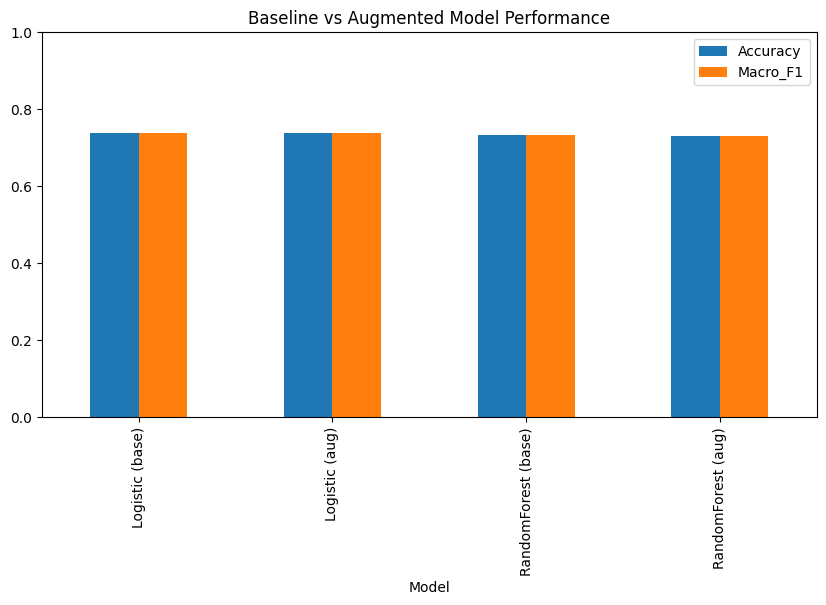

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


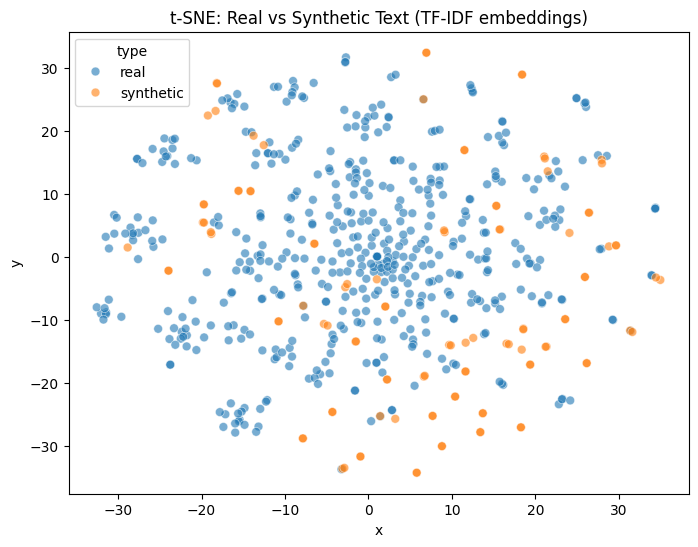

Saved models and CSVs in working directory.


In [ ]:

!pip install -q nltk scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, random, string, joblib
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


columns = ['target','ids','date','flag','user','text']
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin1', names=columns)
df = df[['text','target']]
df = df[df['target'].isin([0,4])]                # keep only positive/negative
df['label'] = df['target'].apply(lambda x: 1 if x==4 else 0)

print("Raw rows:", len(df))
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = str(text).lower()
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df_small = df.sample(n=min(subset_size, len(df)), random_state=42).copy()
df_small['clean_text'] = df_small['text'].apply(clean_text)
print("Using subset rows:", len(df_small))

vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1,3))
X = vectorizer.fit_transform(df_small['clean_text'])
y = df_small['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

def train_and_report(model, X_tr, X_te, y_tr, y_te, name="Model"):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    acc = accuracy_score(y_te, pred)
    f1 = f1_score(y_te, pred, average='macro')
    print(f"\n{name} Accuracy: {acc:.4f}  |  Macro F1: {f1:.4f}")
    print(classification_report(y_te, pred))
    cm = confusion_matrix(y_te, pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()
    return model, pred

print(">>> Baseline: Logistic Regression")
lr = LogisticRegression(max_iter=300)
lr, lr_pred = train_and_report(lr, X_train, X_test, y_train, y_test, "Logistic Regression")

print(">>> Baseline: Random Forest")
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf, rf_pred = train_and_report(rf, X_train, X_test, y_train, y_test, "Random Forest")

baseline_results = {
    "lr_acc": accuracy_score(y_test, lr_pred),
    "rf_acc": accuracy_score(y_test, rf_pred)
}

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            w = lemma.name().replace("_"," ").lower()
            if w != word:
                synonyms.add(w)
    return list(synonyms)

def synonym_replacement(words, n):
    new_words = words.copy()
    candidates = [w for w in words if len(get_synonyms(w))>0]
    random.shuffle(candidates)
    n = min(n, len(candidates))
    for i in range(n):
        w = candidates[i]
        syns = get_synonyms(w)
        if syns:
            new_words = [random.choice(syns) if x==w else x for x in new_words]
    return new_words

def random_deletion(words, p):
    if len(words)==1:
        return words
    out = [w for w in words if random.random() > p]
    return out if len(out)>0 else [random.choice(words)]

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        i, j = random.sample(range(len(new_words)), 2)
        new_words[i], new_words[j] = new_words[j], new_words[i]
    return new_words

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        candidates = [w for w in new_words if len(get_synonyms(w))>0]
        if not candidates: break
        word = random.choice(candidates)
        syns = get_synonyms(word)
        insert_word = random.choice(syns)
        idx = random.randint(0, len(new_words))
        new_words.insert(idx, insert_word)
    return new_words

def eda_augment(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=1):
    words = sentence.split()
    augmented = []
    n_words = max(1, len(words))
    n_sr = max(1, int(alpha_sr * n_words))
    n_ri = max(1, int(alpha_ri * n_words))
    n_rs = max(1, int(alpha_rs * n_words))
    for _ in range(num_aug):
        aug_words = synonym_replacement(words, n_sr)
        aug_words = random_insertion(aug_words, n_ri)
        aug_words = random_swap(aug_words, n_rs)
        aug_words = random_deletion(aug_words, p_rd)
        augmented.append(" ".join(aug_words))
    return augmented

X_train_texts = [df_small['clean_text'].iloc[i] for i in X_train.nonzero()[0]]

train_idx, test_idx = train_test_split(df_small.index, stratify=df_small['label'], test_size=0.3, random_state=42)
train_df = df_small.loc[train_idx].reset_index(drop=True)
test_df = df_small.loc[test_idx].reset_index(drop=True)
print("Train size:", len(train_df), "Test size:", len(test_df))
count_by_label = train_df['label'].value_counts()
print("Train class counts before augmentation:\n", count_by_label)

minority_label = count_by_label.idxmin()
majority_count = count_by_label.max()
target_per_class = majority_count
augment_limit = 8000

aug_texts = []
aug_labels = []
generated = 0
for idx, row in train_df[train_df['label']==minority_label].iterrows():
    if generated >= target_per_class - count_by_label[minority_label] or generated >= augment_limit:
        break
    new_texts = eda_augment(row['clean_text'], num_aug=2)
    for t in new_texts:
        aug_texts.append(t)
        aug_labels.append(minority_label)
        generated += 1
        if generated >= (target_per_class - count_by_label[minority_label]) or generated >= augment_limit:
            break

print("Generated synthetic samples:", len(aug_texts))


aug_df = pd.DataFrame({'clean_text': aug_texts, 'label': aug_labels})
train_augmented_df = pd.concat([train_df[['clean_text','label']], aug_df], ignore_index=True).sample(frac=1, random_state=42)
print("New train class counts:\n", train_augmented_df['label'].value_counts())

vectorizer_aug = TfidfVectorizer(max_features=8000, ngram_range=(1,3))
X_train_aug = vectorizer_aug.fit_transform(train_augmented_df['clean_text'])
y_train_aug = train_augmented_df['label']
X_test_aug = vectorizer_aug.transform(test_df['clean_text'])
y_test_aug = test_df['label']

print(">>> Augmented: Logistic Regression")
lr_aug = LogisticRegression(max_iter=300)
lr_aug, lr_aug_pred = train_and_report(lr_aug, X_train_aug, X_test_aug, y_train_aug, y_test_aug, "Logistic Regression (Augmented)")

print(">>> Augmented: Random Forest")
rf_aug = RandomForestClassifier(n_estimators=150, random_state=42)
rf_aug, rf_aug_pred = train_and_report(rf_aug, X_train_aug, X_test_aug, y_train_aug, y_test_aug, "Random Forest (Augmented)")

def metrics(y_true, y_pred):
    return {"accuracy": accuracy_score(y_true, y_pred), "macro_f1": f1_score(y_true, y_pred, average='macro')}

baseline_lr = metrics(y_test, lr_pred)
aug_lr = metrics(y_test_aug, lr_aug_pred)
baseline_rf = metrics(y_test, rf_pred)
aug_rf = metrics(y_test_aug, rf_aug_pred)

cmp_df = pd.DataFrame({
    'Model': ['Logistic (base)','Logistic (aug)','RandomForest (base)','RandomForest (aug)'],
    'Accuracy': [baseline_lr['accuracy'], aug_lr['accuracy'], baseline_rf['accuracy'], aug_rf['accuracy']],
    'Macro_F1': [baseline_lr['macro_f1'], aug_lr['macro_f1'], baseline_rf['macro_f1'], aug_rf['macro_f1']]
})
print(cmp_df)

cmp_df.set_index('Model')[['Accuracy','Macro_F1']].plot(kind='bar', figsize=(10,5))
plt.title("Baseline vs Augmented Model Performance")
plt.ylim(0,1)
plt.show()

n_vis = 500
real_sample = train_df.sample(n=min(n_vis, len(train_df)), random_state=42)['clean_text'].tolist()
synthetic_sample = aug_df['clean_text'].sample(n=min(n_vis, len(aug_df)), random_state=42).tolist() if len(aug_df)>0 else []
combined = real_sample + synthetic_sample
labels_vis = ['real']*len(real_sample) + ['synthetic']*len(synthetic_sample)
if combined:
    X_vis = vectorizer_aug.transform(combined).toarray()
    pca = PCA(n_components=50, random_state=42).fit_transform(X_vis)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=800)
    X_emb = tsne.fit_transform(pca)
    df_vis = pd.DataFrame({'x': X_emb[:,0], 'y': X_emb[:,1], 'type': labels_vis})
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_vis, x='x', y='y', hue='type', alpha=0.6, s=40)
    plt.title("t-SNE: Real vs Synthetic Text (TF-IDF embeddings)")
    plt.show()

joblib.dump(lr_aug, "logistic_augmented.pkl")
joblib.dump(rf_aug, "rf_augmented.pkl")
joblib.dump(vectorizer_aug, "tfidf_vectorizer_augmented.pkl")
train_augmented_df.to_csv("augmented_train.csv", index=False)
aug_df.to_csv("generated_synthetic_samples.csv", index=False)
print("Saved models and CSVs in working directory.")
